In [ ]:
#!pip install seaborn

In [1]:
# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Plotting
import matplotlib.pyplot as plt

In [2]:

# FEA Constants
E = 200e9  # Young's modulus (Pa)
A = 0.01   # Cross-sectional area (m^2)
L = 1.0    # Length (m)
F = 1000   # Force applied at node 1 (N)

# Stiffness matrix K for 2-node 1-element pillar
K = (A * E / L) * np.array([[1, -1], [-1, 1]])

# Force vector b
b = np.array([0.0, F])

# Normalize K and b for quantum compatibility
K_norm = K / np.linalg.norm(K)
b_norm = b / np.linalg.norm(b)

print("Normalized stiffness matrix K:")
print(K_norm)
print("Normalized force vector b:")
print(b_norm)


Normalized stiffness matrix K:
[[ 0.5 -0.5]
 [-0.5  0.5]]
Normalized force vector b:
[0. 1.]


In [3]:
n_qubits = 3  # Number of system qubits.
n_shots = 10 ** 6  # Number of quantum measurements.
tot_qubits = n_qubits + 1  # Addition of an ancillary qubit.
ancilla_idx = n_qubits  # Index of the ancillary qubit (last position).
steps = 30  # Number of optimization steps
eta = 0.8  # Learning rate
q_delta = 0.001  # Initial spread of random quantum weights
rng_seed = 0  # Seed for random number generator

In [4]:
# Coefficients of the linear combination A = c_0 A_0 + c_1 A_1 ...
c = np.array([1.0, 0.2, 0.2])

def U_b():
    """Unitary matrix rotating the ground state to the problem vector |b> = U_b |0>."""
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def CA(idx):
    """Controlled versions of the unitary components A_l of the problem matrix A."""
    if idx == 0:
        # Identity operation
        None

    elif idx == 1:
        qml.CNOT(wires=[ancilla_idx, 0])
        qml.CZ(wires=[ancilla_idx, 1])

    elif idx == 2:
        qml.CNOT(wires=[ancilla_idx, 0])

In [5]:
def variational_block(weights):
    """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
    # We first prepare an equal superposition of all the states of the computational basis.
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

    # A very minimal variational circuit.
    for idx, element in enumerate(weights):
        qml.RY(element, wires=idx)

In [6]:
dev_mu = qml.device("lightning.qubit", wires=tot_qubits)

@qml.qnode(dev_mu, interface="autograd")
def local_hadamard_test(weights, l=None, lp=None, j=None, part=None):

    # First Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
    # phase gate.
    if part == "Im" or part == "im":
        qml.PhaseShift(-np.pi / 2, wires=ancilla_idx)

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # Controlled application of the unitary component A_l of the problem matrix A.
    CA(l)

    # Adjoint of the unitary U_b associated to the problem vector |b>.
    # In this specific example Adjoint(U_b) = U_b.
    U_b()

    # Controlled Z operator at position j. If j = -1, apply the identity.
    if j != -1:
        qml.CZ(wires=[ancilla_idx, j])

    # Unitary U_b associated to the problem vector |b>.
    U_b()

    # Controlled application of Adjoint(A_lp).
    # In this specific example Adjoint(A_lp) = A_lp.
    CA(lp)

    # Second Hadamard gate applied to the ancillary qubit.
    qml.Hadamard(wires=ancilla_idx)

    # Expectation value of Z for the ancillary qubit.
    return qml.expval(qml.PauliZ(wires=ancilla_idx))

In [7]:
def mu(weights, l=None, lp=None, j=None):
    """Generates the coefficients to compute the "local" cost function C_L."""

    mu_real = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Re")
    mu_imag = local_hadamard_test(weights, l=l, lp=lp, j=j, part="Im")

    return mu_real + 1.0j * mu_imag

In [8]:
def psi_norm(weights):
    """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
    norm = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            norm = norm + c[l] * np.conj(c[lp]) * mu(weights, l, lp, -1)

    return abs(norm)

In [9]:
def cost_loc(weights):
    """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
    mu_sum = 0.0

    for l in range(0, len(c)):
        for lp in range(0, len(c)):
            for j in range(0, n_qubits):
                mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(weights, l, lp, j)

    mu_sum = abs(mu_sum)

    # Cost function C_L
    return 0.5 - 0.5 * mu_sum / (n_qubits * psi_norm(weights))

In [10]:
np.random.seed(rng_seed)
w = q_delta * np.random.randn(n_qubits, requires_grad=True)

In [11]:
#opt = qml.GradientDescentOptimizer(eta)
opt = qml.AdamOptimizer(eta)

In [12]:
cost_history = []
for it in range(steps):
    w, cost = opt.step_and_cost(cost_loc, w)
    print("Step {:3d}       Cost_L = {:9.7f}".format(it, cost))
    cost_history.append(cost)

Step   0       Cost_L = 0.0089888
Step   1       Cost_L = 0.1237400
Step   2       Cost_L = 0.0074220
Step   3       Cost_L = 0.0221629
Step   4       Cost_L = 0.0600698
Step   5       Cost_L = 0.0583040
Step   6       Cost_L = 0.0345639
Step   7       Cost_L = 0.0141323
Step   8       Cost_L = 0.0095826
Step   9       Cost_L = 0.0180468
Step  10       Cost_L = 0.0263379
Step  11       Cost_L = 0.0209385
Step  12       Cost_L = 0.0098046
Step  13       Cost_L = 0.0073984
Step  14       Cost_L = 0.0118275
Step  15       Cost_L = 0.0134575
Step  16       Cost_L = 0.0101531
Step  17       Cost_L = 0.0068601
Step  18       Cost_L = 0.0068760
Step  19       Cost_L = 0.0076490
Step  20       Cost_L = 0.0065159
Step  21       Cost_L = 0.0047017
Step  22       Cost_L = 0.0039245
Step  23       Cost_L = 0.0042642
Step  24       Cost_L = 0.0050086
Step  25       Cost_L = 0.0051306
Step  26       Cost_L = 0.0039590
Step  27       Cost_L = 0.0023012
Step  28       Cost_L = 0.0017062
Step  29      

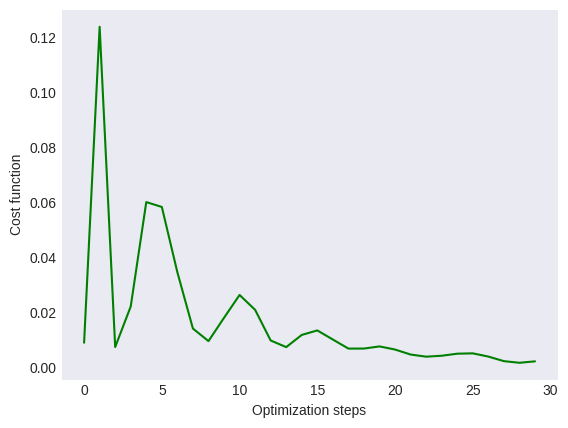

In [13]:
plt.style.use("seaborn-v0_8-dark")
plt.plot(cost_history, "g")
plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Comparison with Classical Approach

In [14]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [15]:
Id = np.identity(2)
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])

A_0 = np.identity(8)
A_1 = np.kron(np.kron(X, Z), Id)
A_2 = np.kron(np.kron(X, Id), Id)

A_num = c[0] * A_0 + c[1] * A_1 + c[2] * A_2
b = np.ones(8) / np.sqrt(8)

In [16]:
print("A = \n", A_num)
print("b = \n", b)

A = 
 [[1.  0.  0.  0.  0.4 0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.4 0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.4 0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.4 0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]
b = 
 [0.35355339 0.35355339 0.35355339 0.35355339 0.35355339 0.35355339
 0.35355339 0.35355339]


In [17]:
A_inv = np.linalg.inv(A_num)
x = np.dot(A_inv, b)
c_probs = (x / np.linalg.norm(x)) ** 2

In [18]:
dev_x = qml.device("lightning.qubit", wires=n_qubits, shots=n_shots)

@qml.qnode(dev_x, interface="autograd")
def prepare_and_sample(weights):

    # Variational circuit generating a guess for the solution vector |x>
    variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

In [19]:
raw_samples = prepare_and_sample(w)

# convert the raw samples (bit strings) into integers and count them
samples = []
for sam in raw_samples:
    samples.append(int("".join(str(bs) for bs in sam), base=2))

q_probs = np.bincount(samples) / n_shots

In [20]:
print("x_n^2 =\n", c_probs)

x_n^2 =
 [0.08445946 0.08445946 0.16554054 0.16554054 0.08445946 0.08445946
 0.16554054 0.16554054]


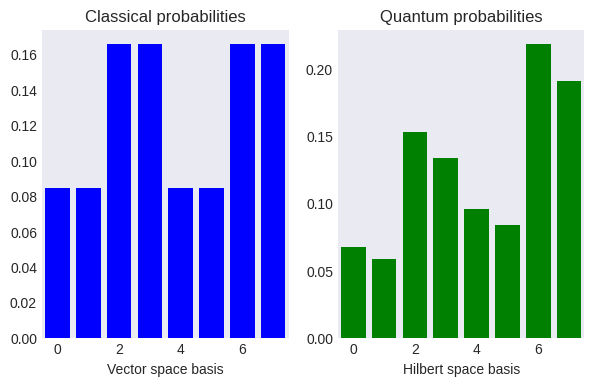

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

plt.show()